In [1]:
train <- read.csv(file = '../../Data/training_data.csv')
train <- train[,-3]

In [ ]:
library(xgboost)
library(Matrix)
library(tidymodels)


prepare the data


In [37]:
train[,'Intensity'] = as.numeric(train[,'Intensity'])
X <- train[,-2]
Y <- train[,2]

X <- as.matrix(X)
Y <- as.matrix(Y)


In [29]:
test.boost = xgboost(X, label = Y,
                      objective = "reg:squarederror",
                      eta = 0.001,
                      max_depth = 10,
                      nround = 100, verbose = 0)
summary(test.boost)

               Length Class              Mode       
handle              1 xgb.Booster.handle externalptr
raw            557801 -none-             raw        
niter               1 -none-             numeric    
evaluation_log      2 data.table         list       
call               16 -none-             call       
params              4 -none-             list       
callbacks           1 -none-             list       
feature_names    4870 -none-             character  
nfeatures           1 -none-             numeric    

Now that we know we have a running boost method on our data, lets get some idea of the performances:

We first get apporoximation of the test error by using a simple validation set approach

In [59]:
id <- sample(nrow(train),nrow(train)*3/4)
val.data <- as.matrix(train[id,])
train.data <- as.matrix(train[-id,])

boost <- xgboost(train.data[,-2], label = train.data[,2],
                      objective = "reg:squarederror",
                      eta = 0.1,
                      max_depth = 10,
                      nround = 150, verbose = 0)




In [60]:
mean((predict(boost,val.data[,-2])-val.data[,2])^2)


[1] 640.6191

Instead of running directly massive CV, we will run the same approach (a bit improved: to reduce the fact that the validation error could depend on the split) as above and plot parameter influences

In [51]:
boosting <- function (trainX,trainY,eta,max_depth){
    xgboost(trainX, label = trainY,
                      objective = "reg:squarederror",
                      eta = eta,
                      max_depth = max_depth,
                      nround = 100, verbose = 0)
}

First we study max_depth

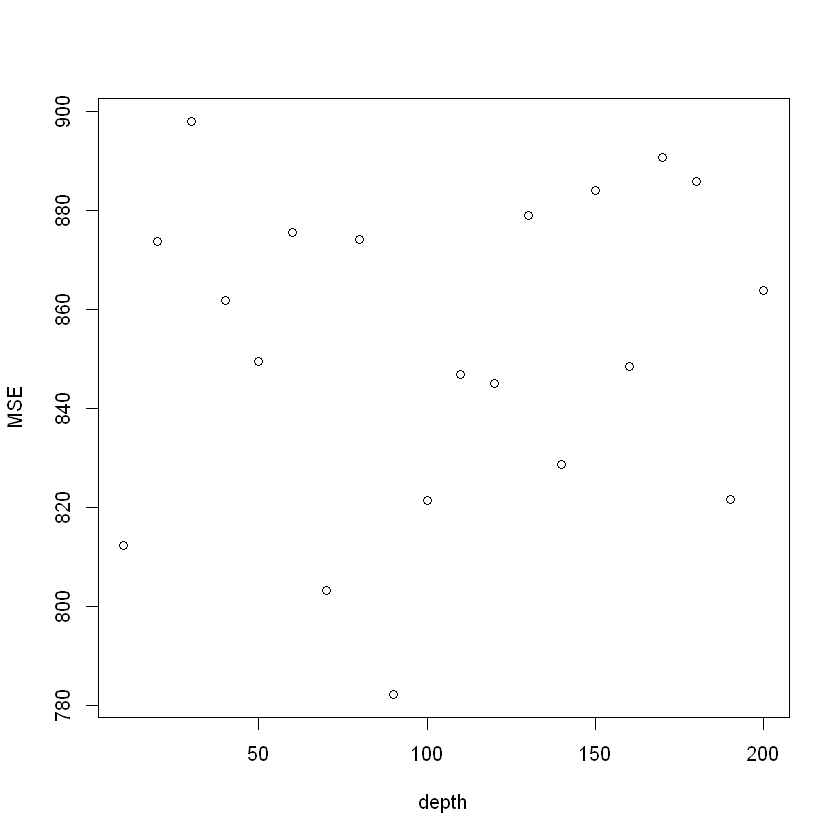

In [79]:
depth <- seq(10,200,by = 10)

MSE = c()
for (n in depth) {
    mse <- c()
    for (i in 1:3){ #to repeat 3 times the splitting -> reduce split dependancy
        id <- sample(nrow(train),nrow(train)*3/4)
        val.data <- as.matrix(train[id,])
        train.data <- as.matrix(train[-id,])
        boost <- boosting(train.data[,-2],train.data[,2],eta = 0.01, max_depth = n)
        mse <- append(mse,mean((predict(boost,val.data[,-2])-val.data[,2])^2))
    }
    MSE <- append(MSE,mean(mse))
}
    
plot(depth,MSE)



Let s do the same thing for eta

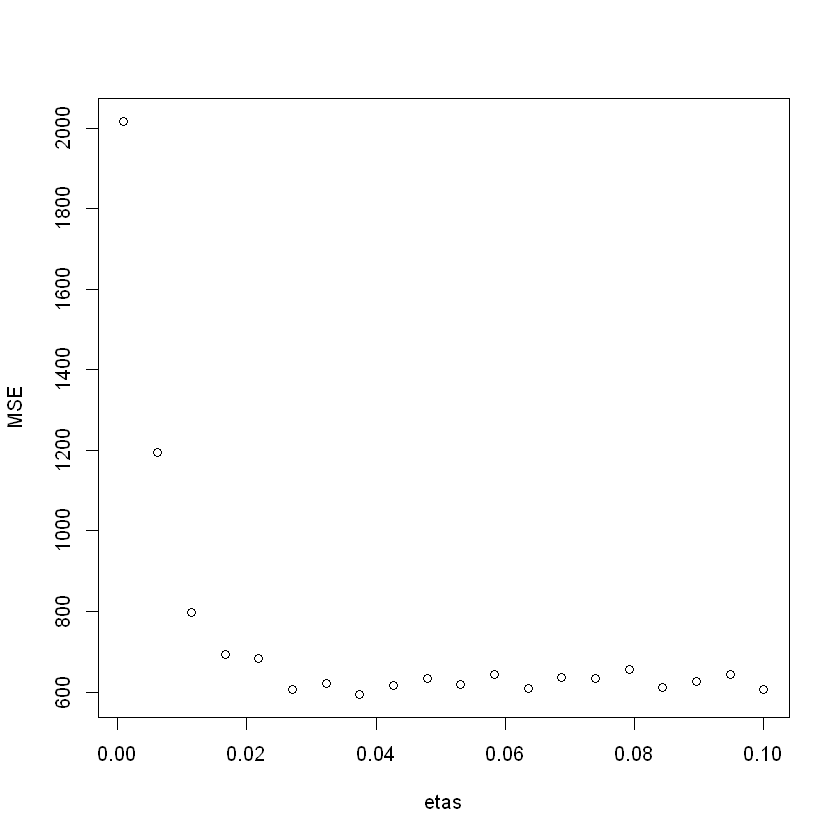

In [83]:
etas <- seq(0.001,0.1, length.out = 20)

MSE = c()
for (eta in etas) {
    mse <- c()
    for (i in 1:3){ #to repeat 3 times the splitting -> reduce split dependancy
        id <- sample(nrow(train),nrow(train)*3/4)
        val.data <- as.matrix(train[id,])
        train.data <- as.matrix(train[-id,])
        boost <- boosting(train.data[,-2],train.data[,2],eta = eta, max_depth = 90)
        mse <- append(mse,mean((predict(boost,val.data[,-2])-val.data[,2])^2))
    }
    MSE <- append(MSE,mean(mse))
}
    
plot(etas,MSE)



So we see that we can optimize paramete a little bit, let's re run a simple boosting with them

In [89]:
mse <- c()
for (i in 1:15) {   
    id <- sample(nrow(train),nrow(train)*0.8)
    val.data <- as.matrix(train[id,])
    train.data <- as.matrix(train[-id,])

    boost <- xgboost(train.data[,-2], label = train.data[,2],
                          objective = "reg:squarederror",
                          eta = 0.04,
                          max_depth = 90,
                          nround = 1000, verbose = 0)
    mse <- append(mse,mean((predict(boost,val.data[,-2])-val.data[,2])^2))
}
mean(mse)

[1] 630.3451

We will try this version of boosting onto the test set.

In [94]:
#load data
test <- read.csv(file = '../../Data/test_data.csv')
test <- test[,-1]
test$Intensity <- as.numeric(test$Intensity)
test <- as.matrix(test)

#train boost on the whole training set
test.boost <- xgboost(X, label = Y,
                          objective = "reg:squarederror",
                          eta = 0.04,
                          max_depth = 90,
                          nround = 1500, verbose = 0)
result <- predict(test.boost,test)


[1] 20.63334 45.62839 19.56024 54.28479 30.60099 68.78225 35.85529 31.19565
 [9] 38.50903 51.95588 16.27239 48.74418 38.11294 40.77680 38.99263 40.19213
[17] 54.27519 23.82881 33.37169 69.85188 48.46401 30.96628 47.29598 67.41740
[25] 27.77188 41.56405 62.58897 50.29924 74.01311 30.78002 45.63660 36.98704
[33] 15.76004 43.58845 35.79543 42.54114 57.43151 52.34647 46.78532 40.79007
[41] 43.35679 54.14470 51.68208 53.82822 50.57734 46.09200 24.73578 37.47602
[49] 26.20219 35.25788 34.33837 51.72608 65.93772 43.77193 28.97860 29.47592
[57] 40.66729 32.71811 35.53012 49.03729 35.35303 28.47931 40.49978 35.51170
[65] 59.53918 50.53627 38.20383 56.09190

In [108]:
id <- 1:68
final.data <- data.frame(Id = id,VALENCE.PLEASANTNESS = result)
write.csv(final.data,"../../Submission/Boosting.csv",row.names = FALSE)